# Data Reading and exploration

In [1]:
#Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
import re
import gensim

# Google Drive
from google.colab import drive

# Math and Visulaization
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

# DL
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#!pip install pandas-profiling==2.7.1

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv("/content/drive/MyDrive/NLP/Project/Dataset/Corona_NLP_train.csv",encoding='latin1')
test = pd.read_csv("/content/drive/MyDrive/NLP/Project/Dataset/Corona_NLP_test.csv",encoding='latin1')

In [5]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
#pp.ProfileReport(train)

In [7]:
print("Total number of tweets: ",len(train['OriginalTweet']))
print("Total number of Sentiments: ",len(train['Sentiment']))
# No missing values on these two features

Total number of tweets:  41157
Total number of Sentiments:  41157


In [8]:
# Remove duplicate rows
train.drop_duplicates(inplace= True)
test.drop_duplicates(inplace=True)

In [9]:
# Drop rows with missing values (No need to do so as no missing tweets nor labels)
#train.dropna(inplace=True)
#test.dropna(inplace=True)

In [10]:
train['tweet'] = train['OriginalTweet']
train['tweet'] = train['tweet'].astype(str)

test['tweet'] = test.OriginalTweet
test['tweet'] = test['tweet'].astype(str)

# Data Preprocessing

In [11]:
# Mapping the 5 classes to 3
def change_classes(sentiment):
    if sentiment == "Extremely Positive":
        return 'Positive'
    elif sentiment == "Positive":
        return 'Positive'
    elif sentiment == "Extremely Negative":
        return 'Negative'
    elif sentiment == "Negative":
        return 'Negative'
    else:
        return 'Neutral'

In [12]:
train['Sentiment']=train['Sentiment'].apply(lambda x:change_classes(x))
test['Sentiment']=test['Sentiment'].apply(lambda x:change_classes(x))

In [13]:
# Data Preprocessing
def correct_apostrophe(text):
    return re.sub(r'Â\x92','\'', text)
train['tweet']=train['tweet'].apply(lambda x:correct_apostrophe(x))
test['tweet']=test['tweet'].apply(lambda x:correct_apostrophe(x))

def remove_URLs(text):
    url_removal_regex = re.compile(r'https?://\S+|www\.\S+')
    return url_removal_regex.sub(r'', text)
train['tweet']=train['tweet'].apply(lambda x:remove_URLs(x))
test['tweet']=test['tweet'].apply(lambda x:remove_URLs(x))

def remove_HTML(text):
    html_regex=re.compile(r'<.*?>')
    return html_regex.sub(r'',text)
train['tweet']=train['tweet'].apply(lambda x:remove_HTML(x))
test['tweet']=test['tweet'].apply(lambda x:remove_HTML(x))

def lower(text):
    return text.lower()
train['tweet']=train['tweet'].apply(lambda x:lower(x))
test['tweet']=test['tweet'].apply(lambda x:lower(x))

def remove_numbers(text):
    return re.sub(r'\d+', '', text)
train['tweet']=train['tweet'].apply(lambda x:remove_numbers(x))
test['tweet']=test['tweet'].apply(lambda x:remove_numbers(x))

def remove_mentions(text):
    return re.sub(r'@\w+','',text)
train['tweet']=train['tweet'].apply(lambda x:remove_mentions(x))
test['tweet']=test['tweet'].apply(lambda x:remove_mentions(x))

def remove_hashtags(x):
    return re.sub(r'#\w+','',x)
train['tweet']=train['tweet'].apply(lambda x:remove_hashtags(x))
test['tweet']=test['tweet'].apply(lambda x:remove_hashtags(x))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
train['tweet']=train['tweet'].apply(lambda x:remove_stopwords(x))
test['tweet']=test['tweet'].apply(lambda x:remove_stopwords(x))

def remove_punctuation(text):
    return re.sub(r'[^\w\d\s]', '', text)
train['tweet']=train['tweet'].apply(lambda x:remove_punctuation(x))
test['tweet']=test['tweet'].apply(lambda x:remove_punctuation(x))


In [14]:
def remove_spaces(text):
    return re.sub(r"\s+"," ",text).strip()
train['tweet']=train['tweet'].apply(lambda x:remove_spaces(x))
test['tweet']=test['tweet'].apply(lambda x:remove_spaces(x))

In [15]:
# Take only the important columns [tweet|Sentiment]
train_data = train.iloc[:,5:]
test_data = test.iloc[:,5:]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Train data class distribution')

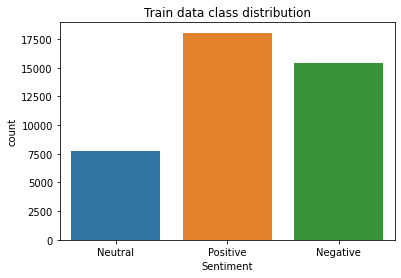

In [16]:
sns.countplot('Sentiment', data=train_data)
plt.title("Train data class distribution")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test data class distribution')

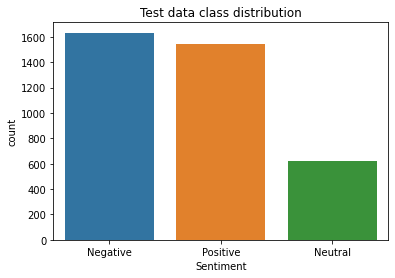

In [17]:
sns.countplot('Sentiment', data=test_data)
plt.title("Test data class distribution")

## TEXT VECTORIZATION

In [18]:
# Mapping class names to numbers
train_data['Sentiment'] = train_data.Sentiment.map({'Negative':0, 'Neutral':1, 'Positive':2})
test_data['Sentiment'] = test_data.Sentiment.map({'Negative':0, 'Neutral':1, 'Positive':2})

In [19]:
# Split data into features and label
X_train = train_data.tweet
X_test = test_data.tweet
y_train = train_data.Sentiment
y_test = test_data.Sentiment

In [20]:
# Start Count vectorizer with maximum features 5000
vect = CountVectorizer(max_features= 5000)
# Extracting Features from train data
X_train_vec = vect.fit_transform(X_train)
# Vectorizing test data with the extracted features
X_test_vec = vect.transform(X_test)


# Models Training

## Naive Bayes

In [21]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_class = nb.predict(X_test_vec)

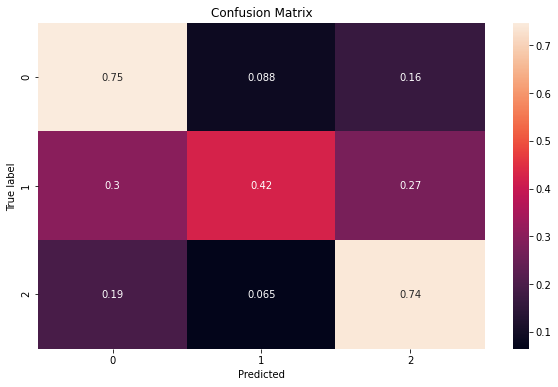

In [22]:
# Confusion mtrix plotting
cf_matrix = metrics.confusion_matrix(y_test, y_pred_class, normalize = 'true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.show()

In [23]:
print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1633
           1       0.52      0.42      0.47       619
           2       0.72      0.74      0.73      1546

    accuracy                           0.69      3798
   macro avg       0.65      0.64      0.64      3798
weighted avg       0.69      0.69      0.69      3798



## Linear SVC

In [24]:
classifier = LinearSVC(max_iter=1500)
classifier.fit(X_train_vec, y_train)

#Predict test data
y_pred_class = classifier.predict(X_test_vec)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


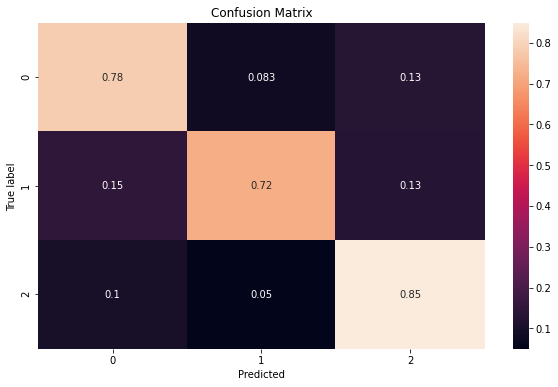

In [25]:
cf_matrix = confusion_matrix(y_test, y_pred_class, normalize = 'true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.show()

In [26]:
print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1633
           1       0.68      0.72      0.70       619
           2       0.82      0.85      0.83      1546

    accuracy                           0.80      3798
   macro avg       0.78      0.79      0.78      3798
weighted avg       0.80      0.80      0.80      3798



## K Nearest Neighbour (KNN)




In [27]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(X_train_vec,y_train)
#Prediction
y_pred_class=knn_classifier.predict(X_test_vec)

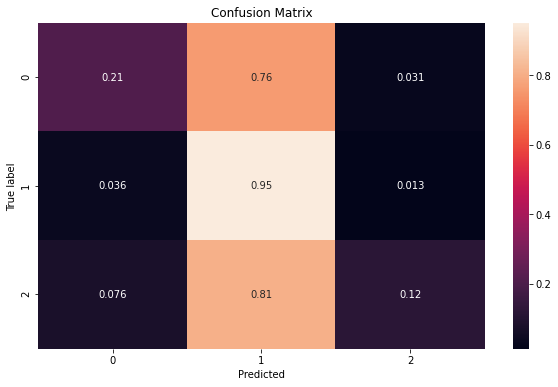

In [28]:
cf_matrix = confusion_matrix(y_test, y_pred_class, normalize = 'true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.show()

In [39]:
print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1633
           1       0.67      0.82      0.74       619
           2       0.84      0.83      0.83      1546

    accuracy                           0.81      3798
   macro avg       0.79      0.81      0.80      3798
weighted avg       0.82      0.81      0.81      3798



## Logistic Regression


In [30]:
LR_classifier = LogisticRegression(max_iter=1000)
LR_classifier.fit(X_train_vec,y_train)
#Prediction
y_pred_class=LR_classifier.predict(X_test_vec)

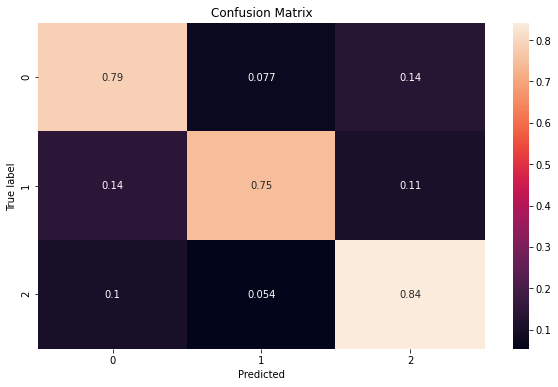

In [31]:
cf_matrix = confusion_matrix(y_test, y_pred_class, normalize = 'true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.show()

In [32]:
print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      1633
           1       0.69      0.75      0.72       619
           2       0.82      0.84      0.83      1546

    accuracy                           0.80      3798
   macro avg       0.78      0.79      0.79      3798
weighted avg       0.81      0.80      0.80      3798



## SGD


In [33]:
sgd_classifier = SGDClassifier(class_weight='balanced', penalty='l2')
sgd_classifier.fit(X_train_vec,y_train)
#Prediction
y_pred_class=sgd_classifier.predict(X_test_vec)

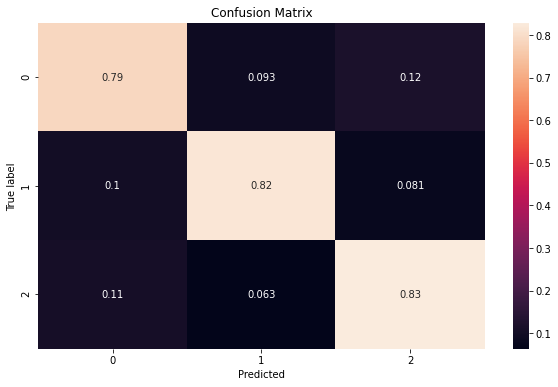

In [34]:
cf_matrix = confusion_matrix(y_test, y_pred_class, normalize = 'true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.show()

In [35]:
print(classification_report(y_test,y_pred_class))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1633
           1       0.67      0.82      0.74       619
           2       0.84      0.83      0.83      1546

    accuracy                           0.81      3798
   macro avg       0.79      0.81      0.80      3798
weighted avg       0.82      0.81      0.81      3798



## Deep Learning

In [36]:
max_len = np.max(X_train.apply(lambda x :len(x)))
max_len

266

In [37]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# Finding Vocab length
vocab_length = len(tokenizer.word_index) + 1

# Tokenizing train and test data
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [40]:
embedding_dim = 16
# Defining sequantial model with 5 layers
dl_model = Sequential()
dl_model.add(layers.Embedding(input_dim=vocab_length, 
                           output_dim=embedding_dim, 
                           input_length=max_len))

dl_model.add(layers.GlobalMaxPool1D())
dl_model.add(layers.Dense(10, activation='relu'))
dl_model.add(layers.Dropout(0.5))
dl_model.add(layers.Dense(3, activation='softmax'))
dl_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
dl_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 266, 16)           615264    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 615,467
Trainable params: 615,467
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Label encoding to be 3*1
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_test = tf.keras.utils.to_categorical(y_test, 3)

In [42]:
# model training
history = dl_model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_test, y_test))

Epoch 1/10
1287/1287 [==============================] - 25s 9ms/step - loss: 0.9920 - accuracy: 0.4885 - val_loss: 0.6634 - val_accuracy: 0.7543
Epoch 2/10
1287/1287 [==============================] - 11s 9ms/step - loss: 0.6529 - accuracy: 0.7357 - val_loss: 0.5373 - val_accuracy: 0.8038
Epoch 3/10
1287/1287 [==============================] - 11s 9ms/step - loss: 0.5273 - accuracy: 0.7931 - val_loss: 0.4888 - val_accuracy: 0.8202
Epoch 4/10
1287/1287 [==============================] - 12s 10ms/step - loss: 0.4509 - accuracy: 0.8175 - val_loss: 0.4741 - val_accuracy: 0.8246
Epoch 5/10
1287/1287 [==============================] - 12s 9ms/step - loss: 0.4184 - accuracy: 0.8320 - val_loss: 0.4729 - val_accuracy: 0.8320
Epoch 6/10
1287/1287 [==============================] - 11s 8ms/step - loss: 0.3736 - accuracy: 0.8447 - val_loss: 0.4981 - val_accuracy: 0.8302
Epoch 7/10
1287/1287 [==============================] - 11s 9ms/step - loss: 0.3443 - accuracy: 0.8490 - val_loss: 0.5103 - val_a

In [43]:
pred = dl_model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


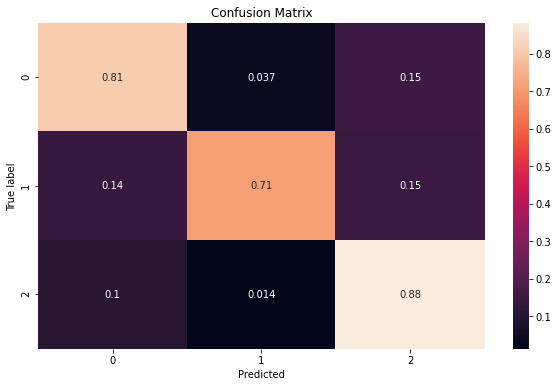

In [44]:
cf_matrix = confusion_matrix(np.argmax(y_test,1),pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.show()

In [45]:
print(classification_report(np.argmax(y_test,axis=1),pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1633
           1       0.84      0.71      0.77       619
           2       0.80      0.88      0.84      1546

    accuracy                           0.82      3798
   macro avg       0.83      0.80      0.81      3798
weighted avg       0.83      0.82      0.82      3798



# References



* Dataset: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification/code?datasetId=863934&sortBy=voteCount
<br>
* good classification: https://colab.research.google.com/github/practical-nlp/practical-nlp/blob/master/Ch4/01_OnePipeline_ManyClassifiers.ipynb#scrollTo=gsUyIBUD5xZI

* Good Notebook: https://www.kaggle.com/datatattle/battle-of-ml-classification-models
* Good Notebook: https://www.kaggle.com/himanshutripathi/covid-19-tweets-analysis-97-accuracy
* Good Analysis on another dataset: https://www.kaggle.com/arbazkhan971/sentiment-analysis-for-beginner-93-accuracy
* Keras: https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding
* Good Theory: https://monkeylearn.com/text-classification/


